In [356]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [357]:
# store all the result
results = []
os.getcwd()

'/home/airren/llm-performance/llmperf/jupyter_analysis'

In [358]:
# traversal all the concurrency sub directories

def dataclean(base_dir, batch_number):
    for concurrent_dir in sorted(os.listdir(base_dir)):
        concurrent_path = os.path.join(base_dir, concurrent_dir)
        if not os.path.isdir(concurrent_path):
            continue
    
        for file in sorted(os.listdir(concurrent_path)):
            if file.endswith("_summary.json"):
                file_path = os.path.join(concurrent_path, file)
                with open(file_path, 'r') as f:
                    data = json.load(f)
    
                token_combo = f"{data.get('mean_input_tokens')}_{data.get('mean_output_tokens')}_{batch_number}"
                
                results.append({
                    "concurrency": data.get("num_concurrent_requests"),
                    "mean_input_tokens": data.get("mean_input_tokens"),
                    "mean_output_tokens": data.get("mean_output_tokens"),
                    "token_combo": token_combo,
                    "inter_token_latency_s_mean": data.get("results_inter_token_latency_s_mean"),
                    "inter_token_latency_s_quantiles_p95": data.get("results_inter_token_latency_s_quantiles_p95"),
                    "inter_token_latency_s_quantiles_p99": data.get("results_inter_token_latency_s_quantiles_p99"),
                    "ttft_s_mean": data.get("results_ttft_s_mean"),
                    "ttft_s_quantiles_p95": data.get("results_ttft_s_quantiles_p95"),
                    "ttft_s_quantiles_p99": data.get("results_ttft_s_quantiles_p99"),
                    "end_to_end_latency_mean_s": data.get("results_end_to_end_latency_s_mean"), 
                    "request_output_throughput_token_per_s_mean": data.get("results_request_output_throughput_token_per_s_mean"),
                    "request_output_throughput_token_per_s_quantiles_p95": data.get("results_request_output_throughput_token_per_s_quantiles_p95"),
                    "request_output_throughput_token_per_s_quantiles_p99": data.get("results_request_output_throughput_token_per_s_quantiles_p99"),
                    "mean_output_throughput_token_per_s": data.get("results_mean_output_throughput_token_per_s"),
                    "number_input_tokens_mean": data.get("results_number_input_tokens_mean"),
                    "number_output_tokens_mean": data.get("results_number_output_tokens_mean"),
                    "success_rate": 1.0 - data.get("results_error_rate", 0.0),
                    "completed_requests": data.get("results_num_completed_requests"),        
                    "benchmark_case": file.replace("_summary.json", "")
                })


In [359]:
# set analysis result dir for 14B
# 两个ipexllm实例在同一个节点
base_dir = "../result_outputs_batch_full_14B_1"
dataclean(base_dir,"14B_1")
print(len(os.listdir(base_dir)))


# set analysis result dir
# 两个ipexllm实例在同一个节点
base_dir = "../result_outputs_batch_full_14B_2"
dataclean(base_dir,"14B_2")
print(len(os.listdir(base_dir)))

127
127


In [360]:
# # set analysis result dir
# # 两个ipexllm实例在同一个节点
# base_dir = "../result_outputs_batch_full_1"
# dataclean(base_dir,"32B_1")
# print(len(os.listdir(base_dir)))

# # set analysis result dir
# # 两个ipexllm实例在同一个节点
# base_dir = "../result_outputs_batch_full_2"
# dataclean(base_dir,"32B_2")
# print(len(os.listdir(base_dir)))


# # set analysis result dir
# # 两个ipexllm实例在同一个节点
# base_dir = "../result_outputs_batch_full_4"
# dataclean(base_dir,"32B_4")
# print(len(os.listdir(base_dir)))

In [361]:
# 转为DataFrame
df = pd.DataFrame(results)
df = df[df['mean_output_tokens'] ==512]
# df = df[df['concurrency'] < 65]
# df = df[df['mean_input_tokens'] ==1024]

df = df.sort_values(by='concurrency')



In [362]:
# 保存到 CSV
csv_output = "benchmark_summary_by_token_combo_14B.csv"
df.to_csv(csv_output, index=False)
print(f"✅ Summary saved to {csv_output}")

✅ Summary saved to benchmark_summary_by_token_combo_14B.csv


In [363]:
# 设置seaborn风格
sns.set(style="whitegrid", font_scale=1.2)

In [364]:
# --------- 统一画图函数 ----------

def plot_metric(metric, ylabel, title, filename):
    plt.figure(figsize=(12, 8))
    
    # 绘制折线图
    ax = sns.lineplot(data=df, x="concurrency", y=metric, hue="token_combo", style="token_combo", markers=True, dashes=False)
    
    # 为每个数据点添加y轴数值标注
    for line in ax.lines:
        x_data = line.get_xdata()
        y_data = line.get_ydata()
        for i in range(len(x_data)):
            if i%4 == 0:
                ax.text(x_data[i], y_data[i], str(round(y_data[i], 2)), ha='center', va='bottom', fontsize=9)
    
    # 设置标题和标签
    plt.title(title)
    plt.xlabel("Concurrency")
    plt.ylabel(ylabel)
    plt.grid(True)
    
    # 设置图例
    plt.legend(title="Input_Tokens → Output_Tokens", bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # 调整布局，避免图例遮挡
    plt.tight_layout()
    
    # 保存和展示图像
    plt.savefig(f"14B_{filename}")
    plt.show()
    plt.close()
    
    print(f"📈 Saved: {filename}")


In [365]:
# --------- 画新增指标图表 ----------

metrics_to_plot = [
   # ("end_to_end_latency_mean_s", "Mean End-to-End Latency (s)", "End-to-End Latency vs Concurrency (by Token Combo)", "latency_vs_concurrency_by_token_combo.png"),
    ("inter_token_latency_s_mean", "Inter-token Latency Mean (s)", "TPOT Mean(low is better)", "inter_token_latency_mean.png"),
    ("inter_token_latency_s_quantiles_p95", "Inter-token Latency P95 (s)", "TPOT P95(low is better)", "inter_token_latency_p95.png"),
    ("inter_token_latency_s_quantiles_p99", "Inter-token Latency P99 (s)", "TPOT P99(low is better)", "inter_token_latency_p99.png"),
    ("ttft_s_mean", "TTFT Mean (s)", "TTFT Mean(low is better)", "ttft_mean.png"),
    ("ttft_s_quantiles_p95", "TTFT P95 (s)", "TTFT P95(low is better)", "ttft_p95.png"),
    ("ttft_s_quantiles_p99", "TTFT P99 (s)", "TTFT P99(low is better)", "ttft_p99.png"),
    ("request_output_throughput_token_per_s_mean", "Request Output Throughput Mean(tokens/sec)", "Request Output Throughput Mean(high is better)", "request_output_throughput_mean.png"),
    ("request_output_throughput_token_per_s_quantiles_p95", "Request Output Throughput P95(tokens/sec)", "Request Output Throughput P95(high is better)", "request_output_throughput_p95.png"),
    ("request_output_throughput_token_per_s_quantiles_p99", "Request Output Throughput P95(tokens/sec)", "Request Output Throughput P99(high is better)", "request_output_throughput_p99.png"),
    ("mean_output_throughput_token_per_s", "Overall Output Throughput (tokens/sec)", "Overall Output Throughput(high is better)", "overall_output_throughput.png")
]

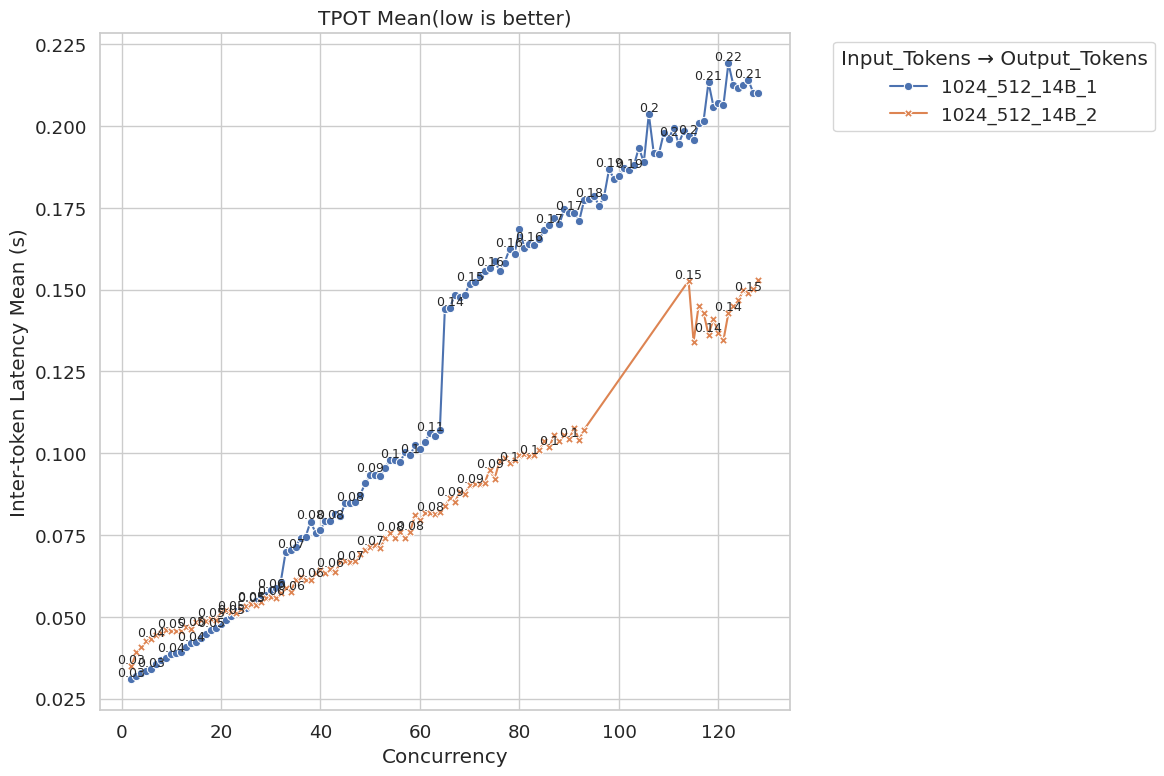

📈 Saved: inter_token_latency_mean.png


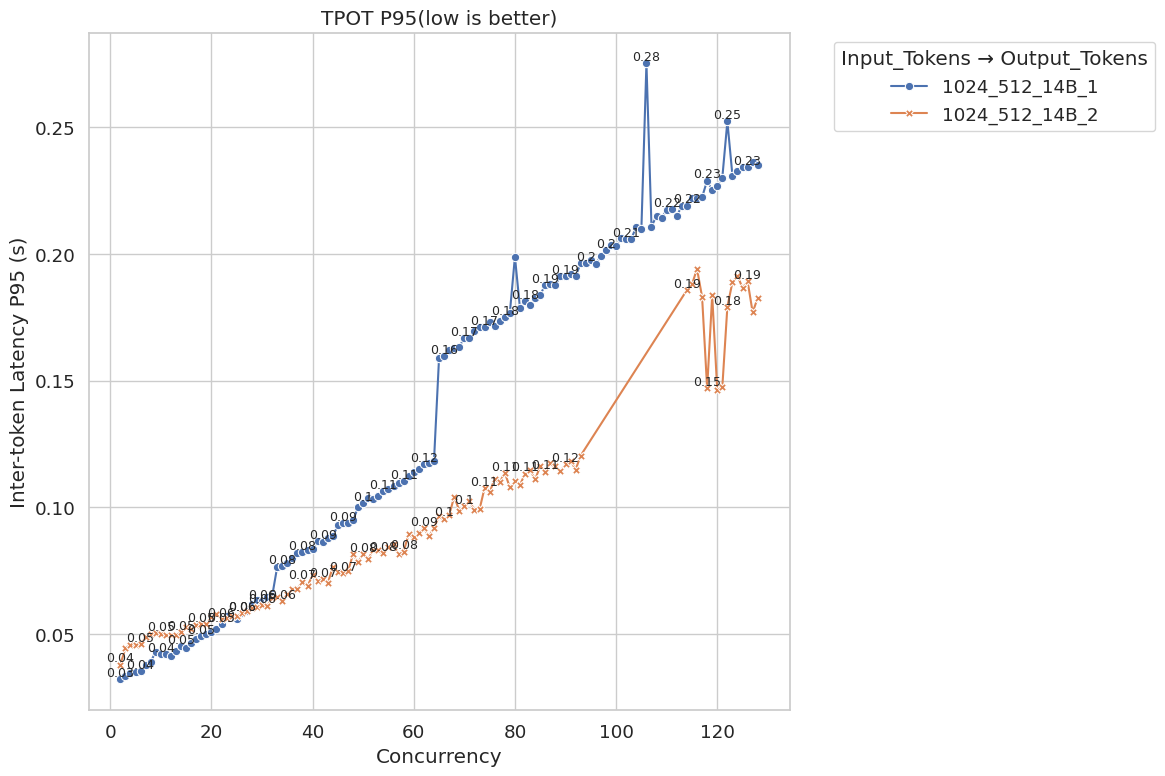

📈 Saved: inter_token_latency_p95.png


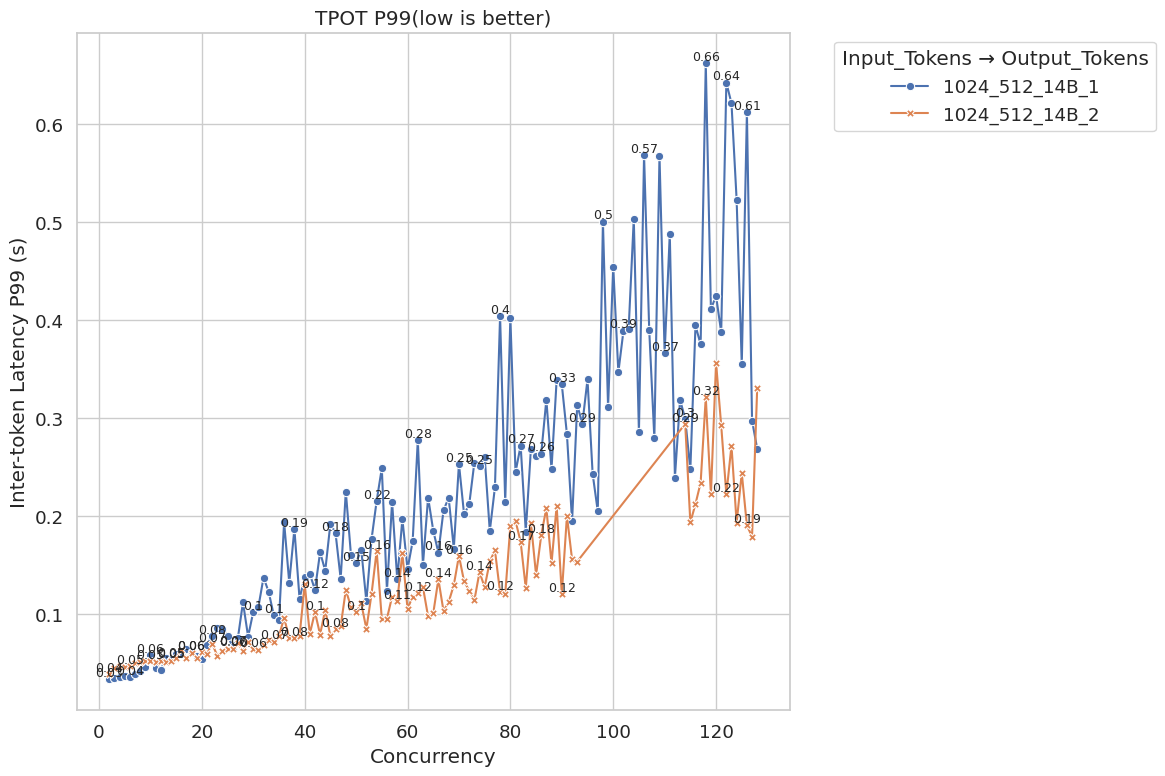

📈 Saved: inter_token_latency_p99.png


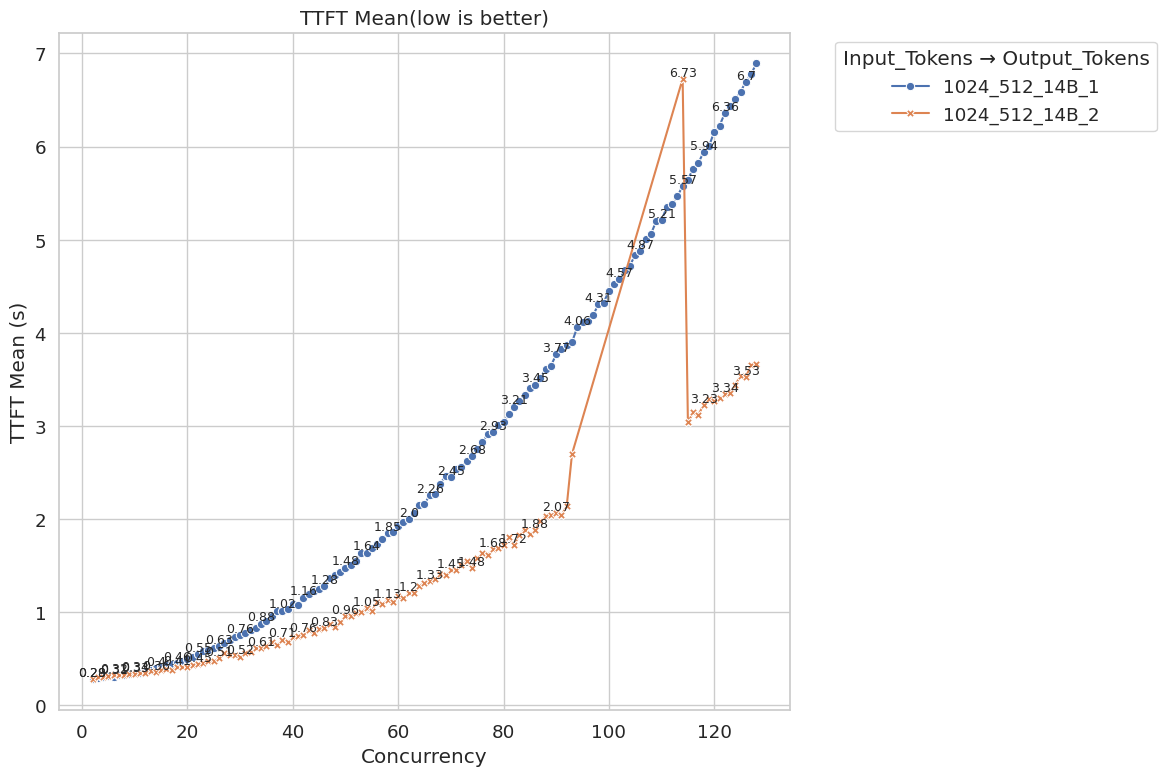

📈 Saved: ttft_mean.png


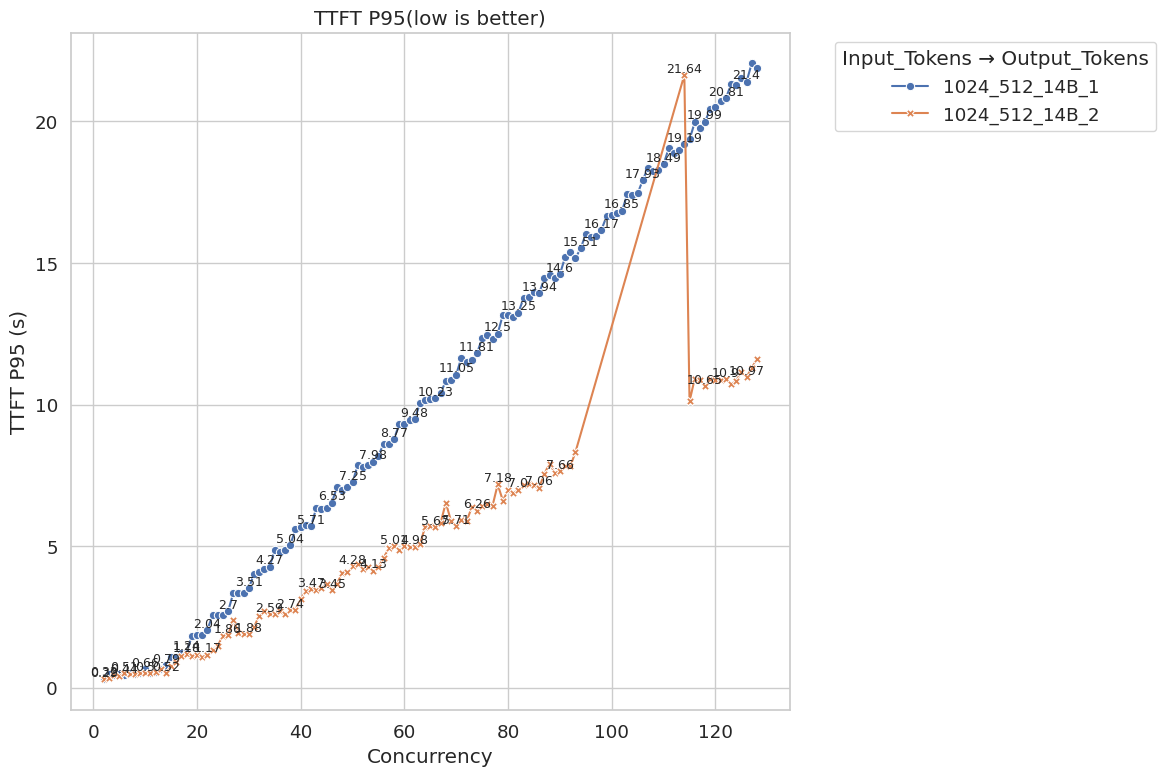

📈 Saved: ttft_p95.png


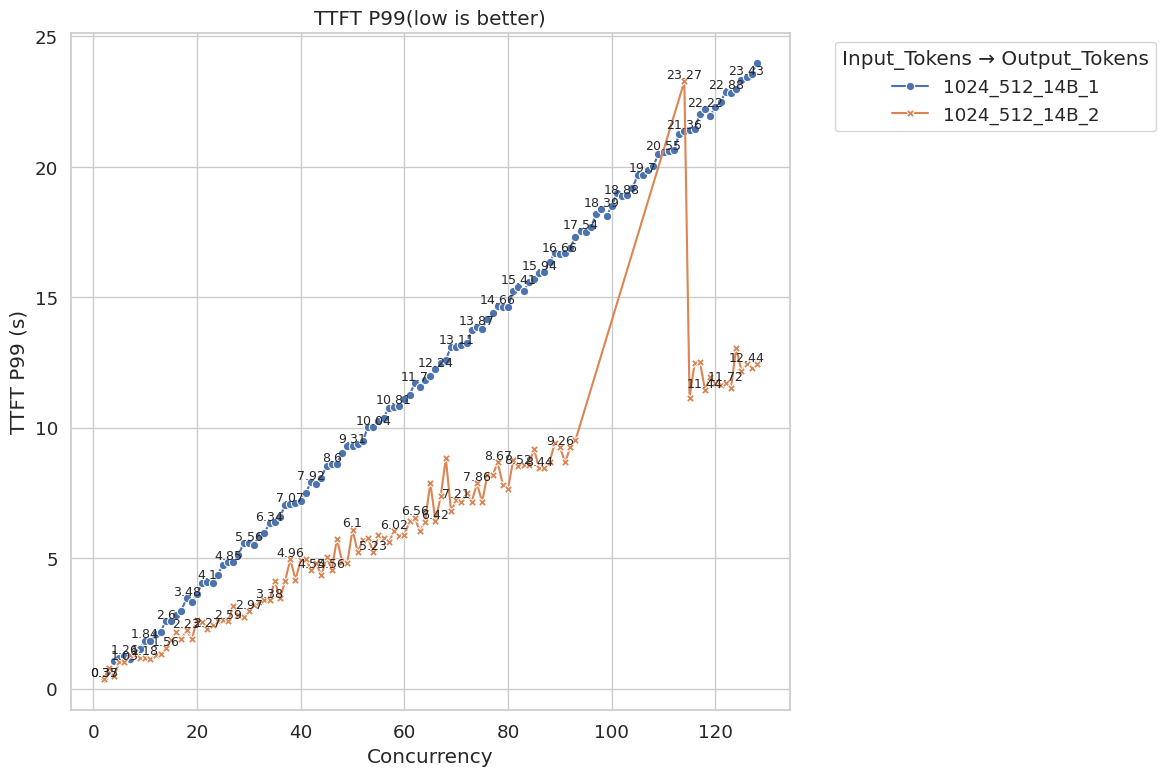

📈 Saved: ttft_p99.png


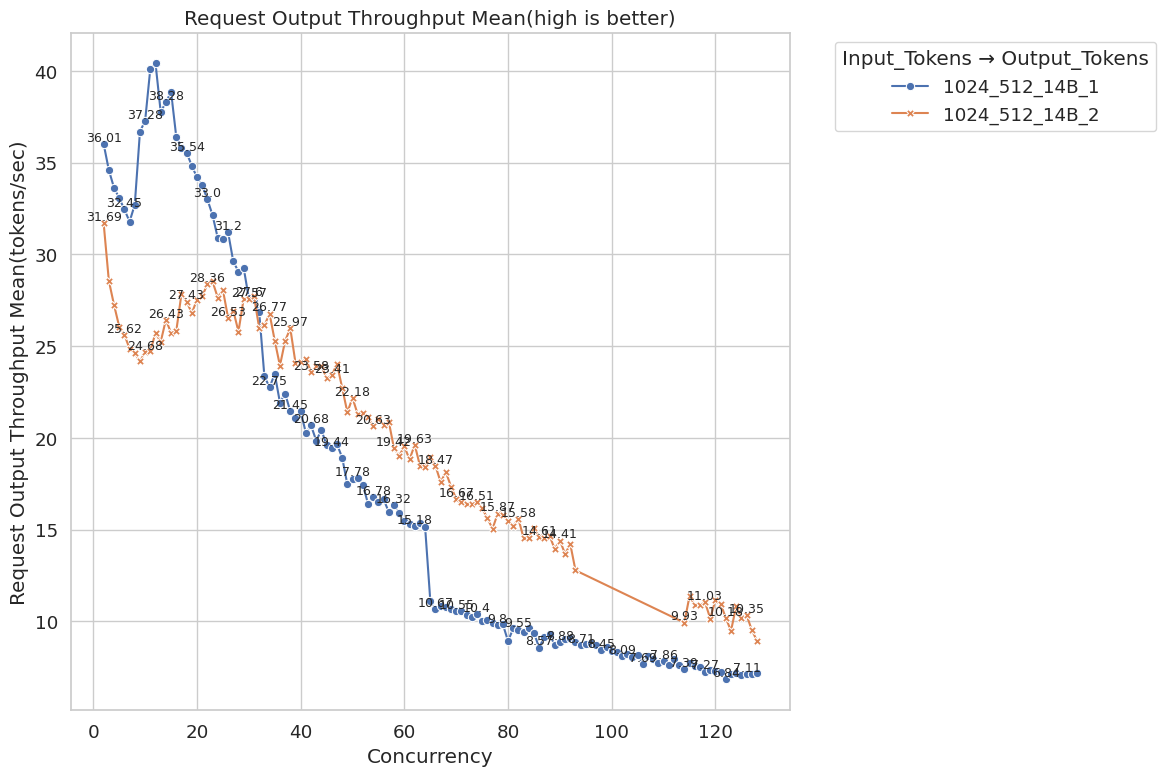

📈 Saved: request_output_throughput_mean.png


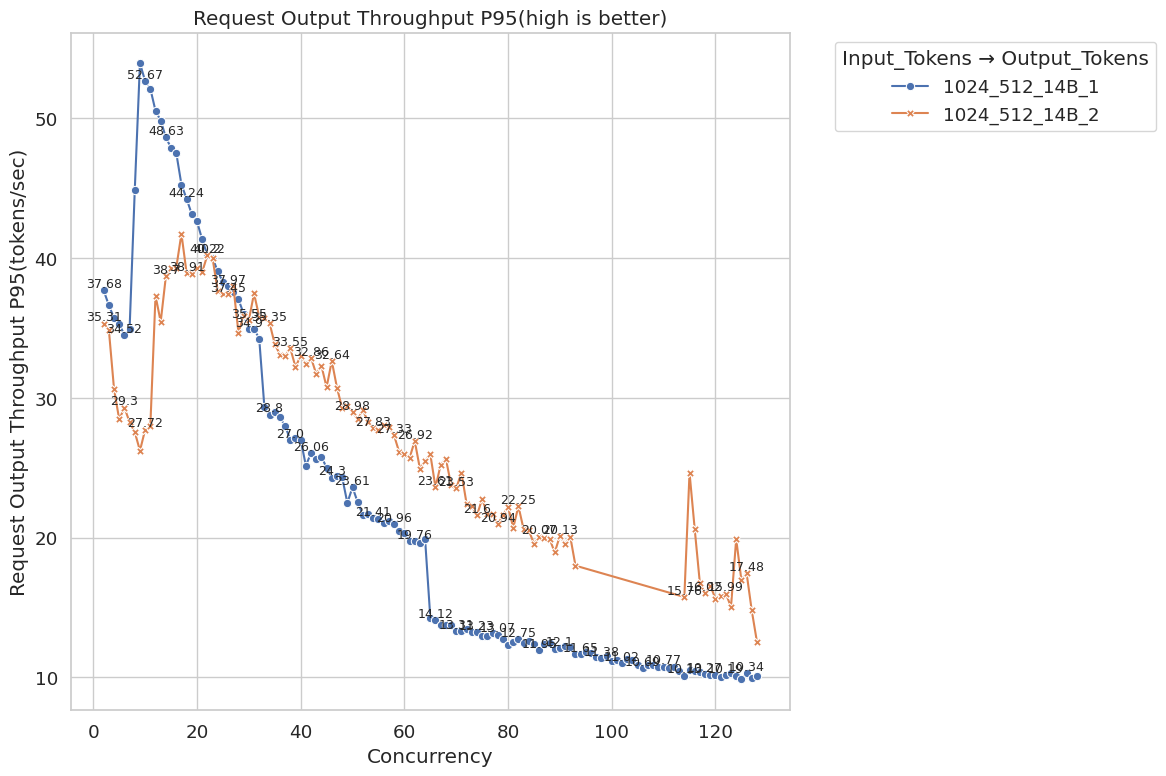

📈 Saved: request_output_throughput_p95.png


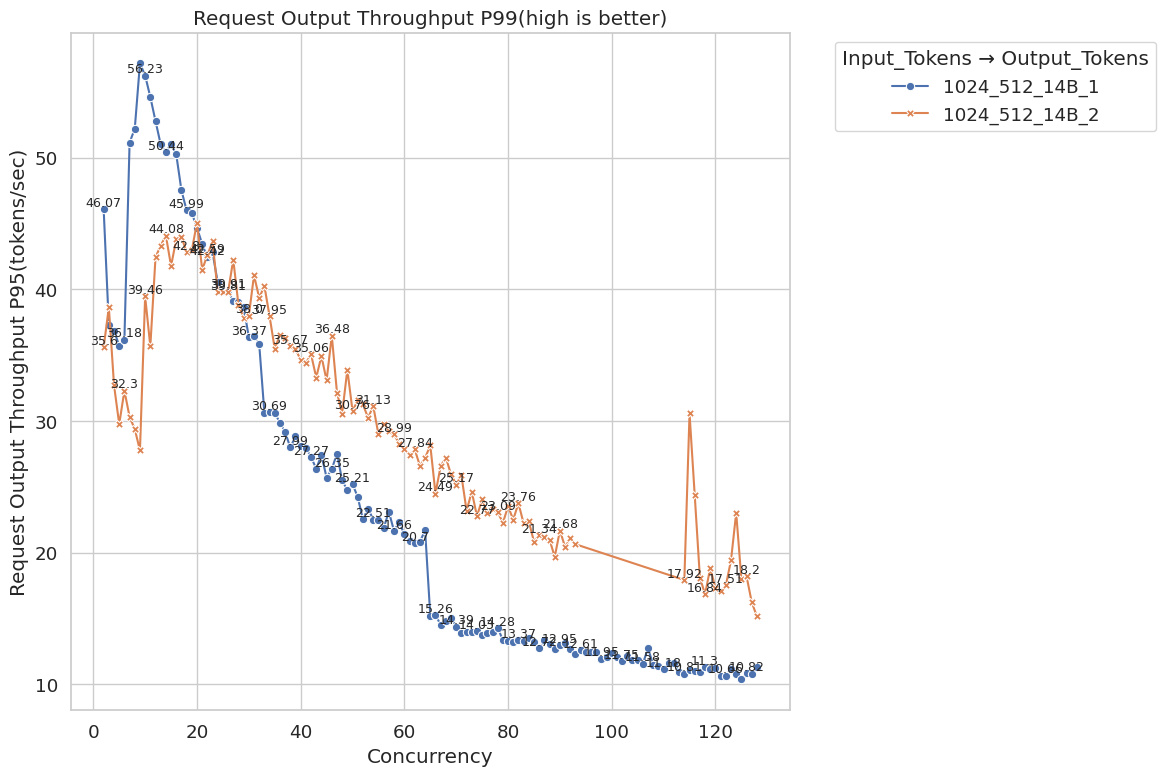

📈 Saved: request_output_throughput_p99.png


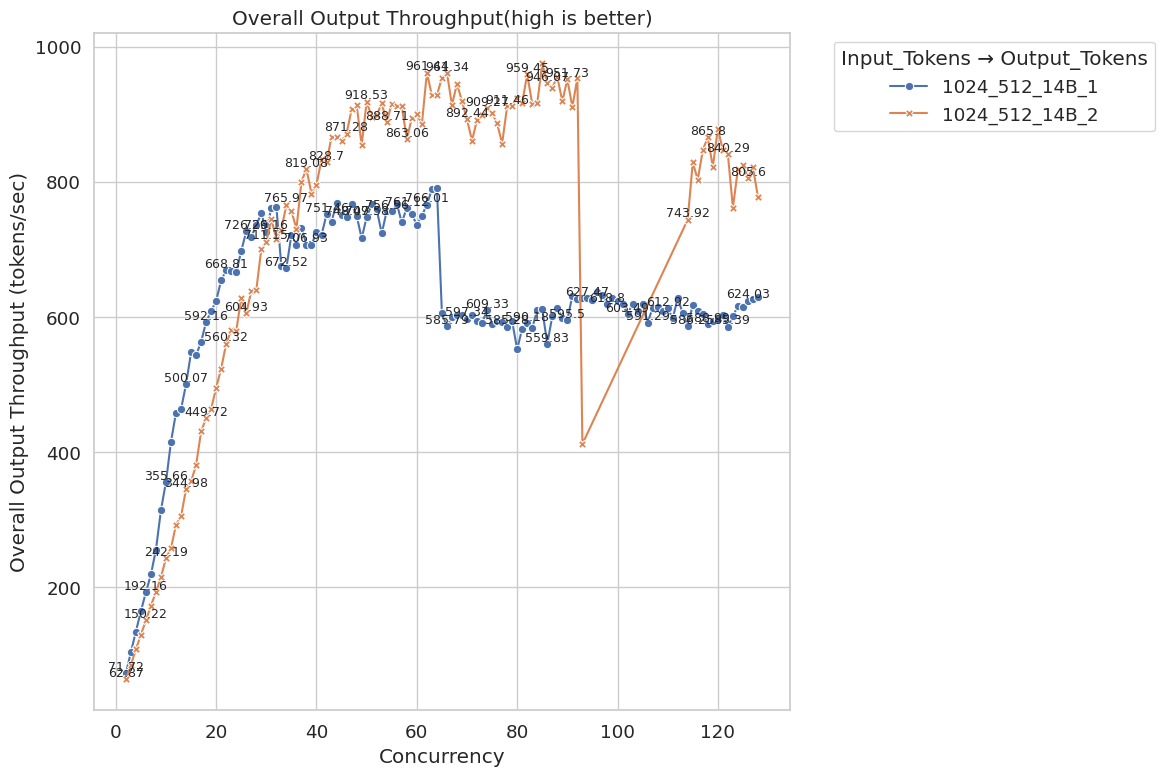

📈 Saved: overall_output_throughput.png
🎯 All multi-token combo metrics plotted!


In [366]:
for metric, ylabel, title, filename in metrics_to_plot:
    plot_metric(metric, ylabel, title, filename)

print("🎯 All multi-token combo metrics plotted!")